In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from functools import partial
from lie_learn.groups.SO3 import change_coordinates as SO3_coordinates
from lie_vae.lie_tools import log_map, rodrigues, map2LieVector, group_matrix_to_eazyz
from lie_vae.nets import ChairsDeconvNet, ChairsEncoder
from lie_vae.decoders import ActionNetWrapper as ActionNet, MLPNet
from lie_vae.datasets import ShapeDataset, SelectedDataset, ObjectsDataset, ThreeObjectsDataset, \
    HumanoidDataset, ColorHumanoidDataset, SingleChairDataset, SphereCubeDataset, ScPairsDataset
from lie_vae.utils import encode
from lie_vae.vae import ChairsVAE
from lie_vae.losses.equivariance_loss import EquivarianceLoss
from lie_vae.lie_tools import s2s1rodrigues, expand_dim, random_group_matrices


In [33]:
def plot_output(images, title="", rgb=False):
    fig, ax = plt.subplots(1, len(images), figsize=(2*len(images), 3))
    for ax, im in zip(ax.flatten(), images):
        if rgb:
            ax.imshow(im.permute([1, 2, 0]).clamp(0, 1).detach())
        else:
            ax.imshow(im[0].detach(), 'gray')
        ax.set_axis_off()
    fig.suptitle(title)
    fig.tight_layout()
    
# def rotation_interpolation():
#     start = torch.rand(3)[None] * 5
#     end = torch.rand(3)[None] * 5
#     t = torch.linspace(0, 1, 10)[:, None]
#     x = (1-t) * start + end * t
#     return rodrigues(x).detach()
    
def rotation_random_walk():
    start = torch.rand(1, 3) * 5
    d = torch.rand(20, 3) * 0.6
    x = d.cumsum(0) + start
    return rodrigues(x).detach()

def decode_vae(vae, pose, content):
    if vae.decoder_mode == "action":
        if vae.latent_mode == "so3":
            angles = group_matrix_to_eazyz(pose)
        elif vea.latent_mode == "normal":
            angles = vector_to_eazyz(pose)
        else:
            raise RuntimeError()

        recon = vae.decoder(angles, content)

    elif vae.decoder_mode == "mlp":
        recon = vae.decoder(pose, content)
    else:
        raise RuntimeError()

    return recon


def encode_vae(vae, img):
    pose, content = vae.encode(img)
    return [pose[0], content[0]]

def plot_reconstructions(versions, titles, rgb=False):
    n_versions = len(versions)
    n_images = len(versions[0])
    
    fig, ax = plt.subplots(n_images, n_versions, figsize=(2*n_versions, 2*n_images))
    for i in range(n_images):
        for j in range(n_versions):
            if rgb:
                ax[i, j].imshow(versions[j][i].permute([1, 2, 0]).clamp(0, 1).detach())
            else:
                ax[i, j].imshow(versions[j][i][0].detach(), 'gray')
            ax[i, j].set_axis_off()
            if i == 0:
                ax[i, j].set_title(titles[j])
    fig.tight_layout()
    
from lie_vae.lie_tools import randomR

def plot_output(images, title="", rgb=False, shape=None, size=None):
    import math
    n = math.ceil(math.sqrt(len(images)))
    if shape is None:
        shape = (n, n)
    if size is None:
        size = [2*x for x in shape]
    fig, axes = plt.subplots(*shape, figsize=size)
    for ax, im in zip(axes.flatten(), images):
        if rgb:
            ax.imshow(im.detach().permute([1, 2, 0]).clamp(0, 1))
        else:
            ax.imshow(im[0].detach(), 'gray')
        ax.set_axis_off()
    if title:
        fig.suptitle(title)
    fig.tight_layout()
    
def rotation_interpolation(n, random_mu=False, device=None):
    start = torch.zeros(1, 3, device=device)
    end = torch.randn(1, 3, device=device)
    end = end / end.norm() * 2 * np.pi * (1 - 1. / n) # Remove endpoint
    end = end + start
    t = torch.linspace(0, 1, n).to(device)[:, None]
    x = (1-t) * start + end * t
    g = rodrigues(x)
    g[0] = torch.eye(3)
    if random_mu:
        mu = random_group_matrices(1, device=device).expand_as(g)
        g = mu.bmm(g)
    return g

def _show(ax, img, rgb):
    if rgb:
        m = img.min()
        img = (img-m) / (img.max() - m)
        img = img
        ax.imshow(np.transpose(img.detach(), [1, 2, 0]))
    else:
        ax.imshow(img[0].detach(), 'gray')

def disentangle(enc, dec, start, end, title, rgb=False):
    imgs = torch.stack([start, end], 0)
    (start_rot, end_rot), (start_cont, end_cont) = enc(imgs)
    start_alg = map2LieVector(log_map(start_rot))
    end_alg = map2LieVector(log_map(end_rot))
    
    n_steps = 6
    
    t = torch.linspace(0, 1, n_steps)[:, None]
    t_first = torch.cat([t, torch.ones_like(t)], 0)
    t_second = torch.cat([torch.zeros_like(t), t], 0)
    rot_traj = rodrigues(start_alg[None] * (1-t_first) + end_alg[None] * t_first)
    cont_traj = start_cont[None] * (1-t_second) + end_cont[None] * t_second
    out = dec(rot_traj, cont_traj)
    
    fig, ax = plt.subplots(2, n_steps+1, figsize=(10, 3))
    for i in range(2):
        for j in range(n_steps+1):
            if i == 0 and j == 0:
                _show(ax[i, j], start, rgb)
            elif i == 1 and j == n_steps:
                _show(ax[i, j], end, rgb)
            else:
                img_i = n_steps * i + j - 1
                _show(ax[i, j], out[img_i], rgb)
            ax[i, j].set_axis_off()
#     fig.tight_layout()
    fig.suptitle(title)

In [3]:
multi_dataset = SelectedDataset()
obj_dataset = ObjectsDataset()
obj3_dataset = ThreeObjectsDataset()
humanoid_dataset = HumanoidDataset()
chumanoid_dataset = ColorHumanoidDataset()
single_dataset = SingleChairDataset()
spherecube_dataset = SphereCubeDataset()
scpairs_dataset = ScPairsDataset()

In [4]:
def xorbit(n, device=None):
    v = expand_dim(torch.tensor([1.0, 0, 0], device=device), n)
    thetas = torch.linspace(0, 2*np.pi, n, device=device)
    s1 = torch.stack([torch.cos(thetas), torch.sin(thetas)], 1)
    return s2s1rodrigues(v, s1) @ random_group_matrices(1, device=device)

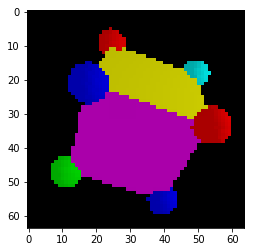

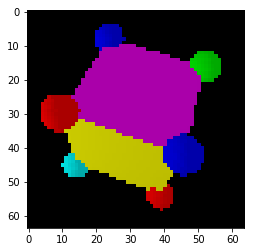

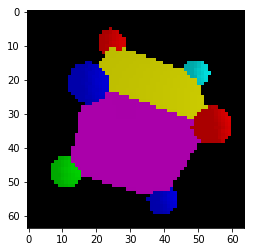

In [5]:
for i in np.random.randint(len(spherecube_dataset), size=1):
    img = spherecube_dataset[i][2]
    for theta in torch.linspace(0, 2*np.pi, 3):
        rot = EquivarianceLoss.rotate(img[None], theta[None])[0]
        plt.imshow(rot.permute([1, 2, 0]))
        plt.show()

In [7]:
device = torch.device('cuda')

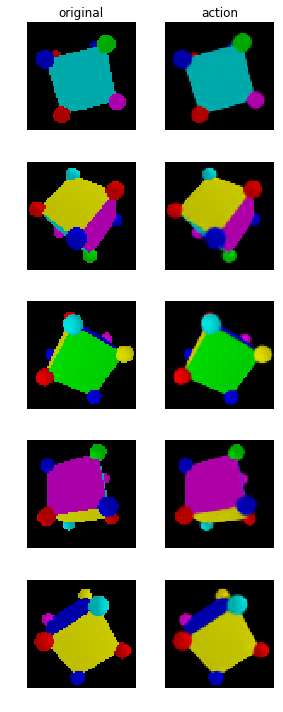

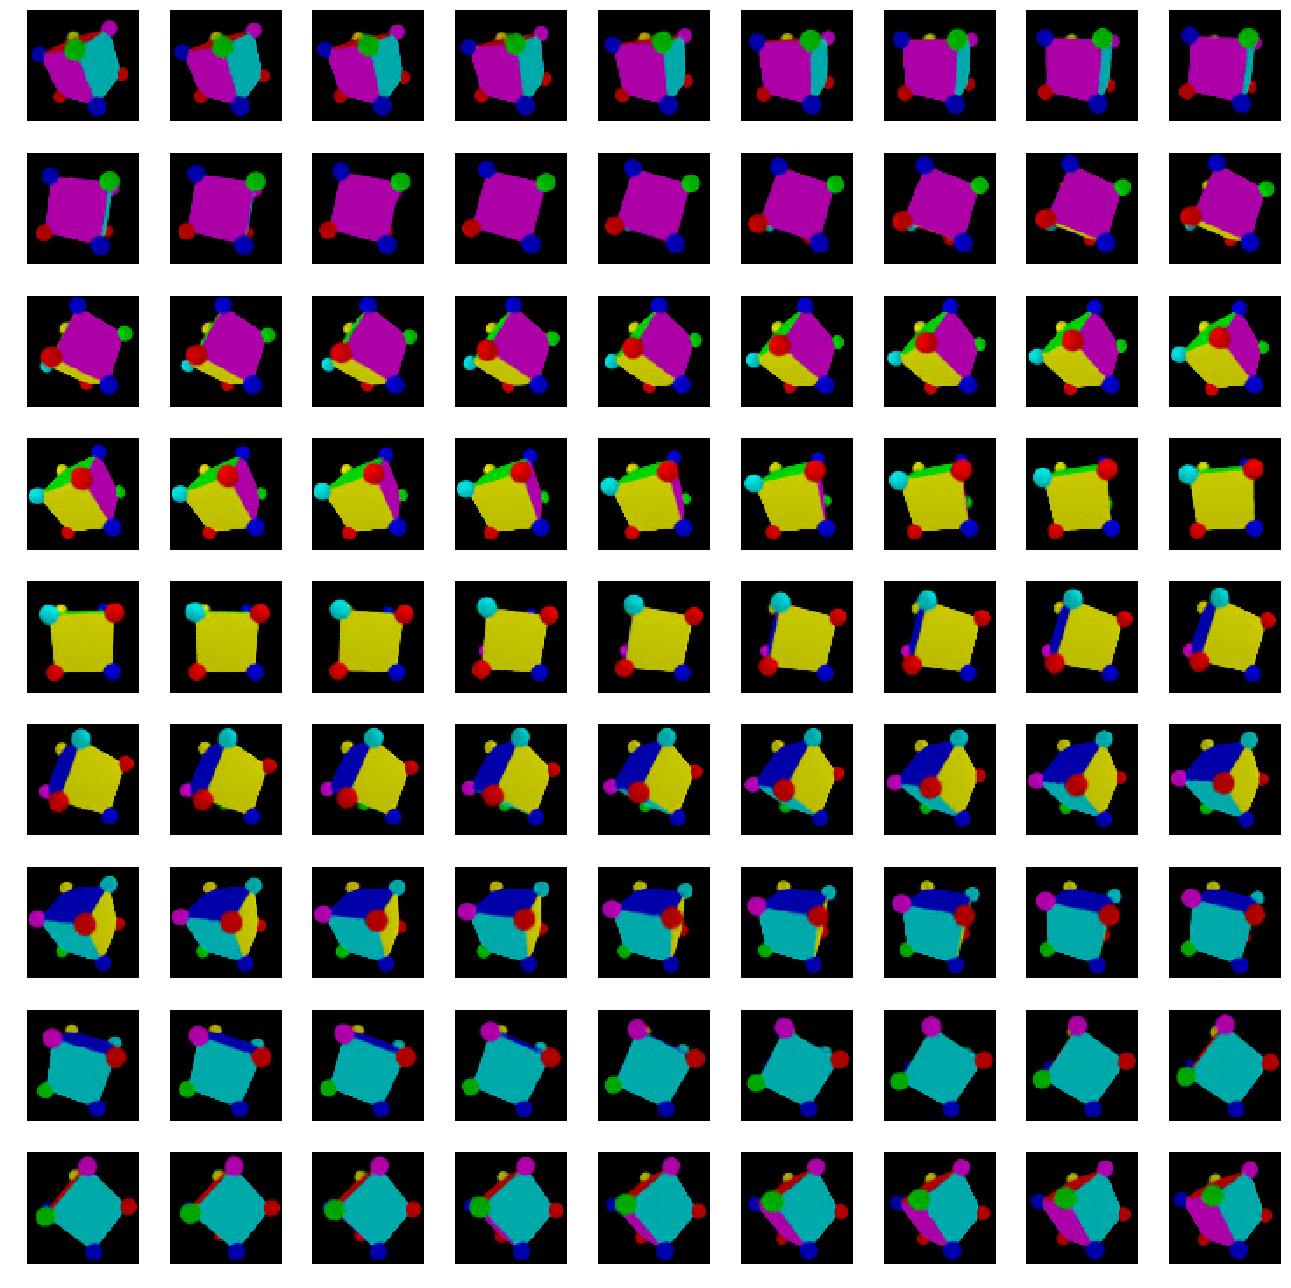

In [9]:
# sc_action = ChairsVAE(
#     latent_mode='so3',
#     decoder_mode='action',
#     deconv_hidden=200,
#     degrees=6,
#     single_id=True,
#     rgb=True)
# sc_action.load_state_dict(torch.load('outputs/sc-action-so3-fat-betasq/model.pickle'))
# sc_action = ChairsVAE(
#     latent_mode='so3',
#     decoder_mode='action'
#     deconv_hidden=30,
#     degrees=10,
#     single_id=True,
#     rgb=True)
# sc_action.load_state_dict(torch.load('outputs/sc-action-so3-slim-betasq/model.pickle'))
# sc_action = ChairsVAE(
#     latent_mode='so3',
#     decoder_mode='action',
#     deconv_hidden=50,
#     degrees=10,
#     deconv_mode='deconv4',
#     single_id=True,
#     rgb=True)
# sc_action.load_state_dict(torch.load('outputs/sc-action-so3-deconv4-betasq/model.pickle'))
sc_action = ChairsVAE(
    latent_mode='so3',
    decoder_mode='action',
    mean_mode='s2s2',
    single_id=True,
    deconv_hidden=200,
    rgb=True,
#     fixed_sigma=0.,
).to(device)
# sc_action.load_state_dict(mean_module_rewrite(torch.load('outputs/sc-action-so3-fat-q-beta3/model.pickle')))
# sc_action.load_state_dict(torch.load('outputs/test_clean/model.pickle'))
# sc_action.load_state_dict(torch.load('outputs/sc-so3-action-fat-s2s2-cont1-betasu/model.pickle'))
# sc_action.load_state_dict(torch.load('outputs/sc-so3-action-fat-s2s2-cont1-betasu/model.pickle'))
# sc_action.load_state_dict(torch.load('outputs/n1/sc-so3-action-fat-s2s2-cont1-beta10/model.pickle'))
# sc_action.load_state_dict(torch.load('outputs/n1/equiv100-beta6/model.pickle'))
# sc_action.load_state_dict(torch.load('outputs/n1/equiv30-beta6/model.pickle'))
# sc_action.load_state_dict(torch.load('outputs/n2/equiv100/model.pickle'))
# sc_action.load_state_dict(torch.load('outputs/n2/equiv100-sigma0.1/model.pickle'))
# sc_action.load_state_dict(torch.load('outputs/n2/equiv100-sigma0.03/model.pickle'))
# sc_action.load_state_dict(torch.load('outputs/n1/equiv100-sigma0.01/model.pickle'))
# sc_action.load_state_dict(torch.load('outputs/n1/equiv100-enccont100/model.pickle'))
# sc_action.load_state_dict(torch.load('outputs/n1/equiv100-enccont1000-sigma0.03/model.pickle'))
# sc_action.load_state_dict(torch.load('outputs/n1/equiv100-enccont3000-sigma0.1/model.pickle'))
# sc_action.load_state_dict(torch.load('outputs/n1/equiv100-enccont3000-sigma0.1-subsample0.1/model.pickle'))
# sc_action.load_state_dict(torch.load('outputs/n1/equiv100-enccont3000-beta7-control1000/model.pickle'))
# sc_action.load_state_dict(torch.load('outputs/n2/equiv100-enccont3000-beta7-control100/model.pickle'))
sc_action.load_state_dict(torch.load('outputs/n1/equiv100-enccont3000-betasx-control/model.pickle'))
# sc_action.load_state_dict(torch.load('outputs/n1/equiv100-enccont3000-betasx-control-subsample0.1/model.pickle'))
# sc_action.load_state_dict(torch.load('outputs/n2/equiv100-enccont3000-beta8-control1000/model.pickle'))
# sc_action.load_state_dict(torch.load('outputs/n1/enccont3000-sigma0.1/model.pickle'))
idxs = np.random.choice(len(spherecube_dataset), size=5, replace=False)
images = torch.stack([spherecube_dataset[i][2] for i in idxs], 0).to(device)
reconstructions = sc_action(images)[0]
plot_reconstructions([images, reconstructions],
                     ['original', 'action'],
                     rgb=True)


g = rotation_interpolation(81, random_mu=True, device=device)
# g = xorbit(81, device=device)
out = sc_action.decode(g[None])[0]

plot_output(out, rgb=True)
plt.show()

In [81]:
n1 = 100
n2 = 5
n3 = 3
g1 = rotation_interpolation(n1, device=device, random_mu=True).repeat(n2*n3, 1, 1)
g2 = rotation_interpolation(n1*n2, device=device).repeat(n3, 1, 1)
g3 = rotation_interpolation(n1*n2*n3, device=device)
# mu = torch.tensor(randomR()).float()[None].expand_as(g1) 
g = g1.bmm(g2).bmm(g3)
out = sc_action.decode(g[None])[0]

In [314]:
n = 200
speed = 3
dir_a = torch.tensor([1., 0., 0.], device=device)
dir_b = torch.tensor([0., 1., 0.], device=device)
t = torch.linspace(0, 2*np.pi, n).to(device)[:, None]
x = t * dir_a + (speed*t) * dir_b
g = rodrigues(x)
g[0] = torch.eye(3, device=device)
mu = torch.eye(3, device=device).expand_as(g)
g = mu.bmm(g)
out = sc_action.decode(g[None])[0]

In [334]:
_, g, img = spherecube_dataset[1]
mu = g.to(device).matmul(sc_action.encode(img[None].to(device))[0][0, 0].inverse())

In [15]:
pieces = 8
a_size = 20
b_size = 60
rots_a = 1
rots_b = pieces
# t_a = np.concatenate([np.repeat(np.linspace(0, 1, (pieces-1)*a_size), [b_size+1, *[1]*(a_size-1)]*(pieces-1)), np.ones(b_size)])
# t_a = np.repeat(np.linspace(0, 1, (pieces-1)*(a_size+1)), [*[b_size, *[1]*(a_size)]*(pieces-1), b_size])


# t_b = np.concatenate([np.tile(np.concatenate([np.linspace(0, 1, b_size), np.zeros(a_size)]), 4), np.linspace(0, 1, b_size)])

# t_b = np.repeat(np.linspace(0, pieces, pieces*b_size), )


parts_a = [*[b_size+1, *[1]*(a_size-1)]*(pieces-1), b_size+1]
parts_b = [*[1]*(b_size), *[a_size+1, *[1]*(b_size-1)]*(pieces-1), 1]
# t_a = np.repeat(np.linspace(0, 2*np.pi, (pieces-1)*a_size+1), [*[b_size, *[1]*(a_size-1)]*(pieces-1), b_size+1])[:, None]
t_a = np.repeat(np.linspace(0, 2*np.pi*rots_a, len(parts_a)), parts_a)[:, None]
t_b = np.repeat(np.linspace(0, 2*np.pi*rots_b, len(parts_b)), parts_b)[:, None]

dir_a, dir_b = torch.tensor([[1, 0, 0], [0, 1, 0]], dtype=torch.float32, device=device)

g = rodrigues(t_a * dir_a).bmm(rodrigues(t_b * dir_b)).to(torch.float32).to(device)
g[0] = torch.eye(3, device=device)
mu = torch.eye(3, device=device)
g = mu.expand_as(g).bmm(g)
out = sc_action.decode(g[None])[0]

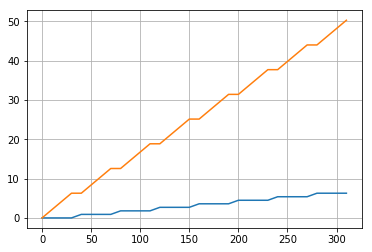

In [347]:
plt.plot(t_a)
plt.plot(t_b)
g = plt.gca().grid()
# plt.gca().set_xticks(np.arange(max(len(t_b), len(t_a))))
plt.show()

In [16]:
from PIL import Image
for i, tensor in enumerate(out):
    tensor = tensor.detach().permute([1, 2, 0]).clamp(0, 1)
    tensor = tensor.mul(255).to(torch.uint8)
    img = Image.fromarray(tensor.cpu().numpy())
    img.save('gif/img{}.png'.format(i))
!ffmpeg  -y -i gif/img%d.png -vf scale=320:-1:flags=lanczos gif/out.mp4
!rm gif/*.png

ffmpeg version 3.4.2-2 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu2)
  configuration: --prefix=/usr --extra-version=2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzmq --enable-libzvbi --

tensor(1.00000e-02 *
       [ 2.4484,  2.7653,  3.6595,  3.2149,  7.8822,  8.0079], device='cuda:0')


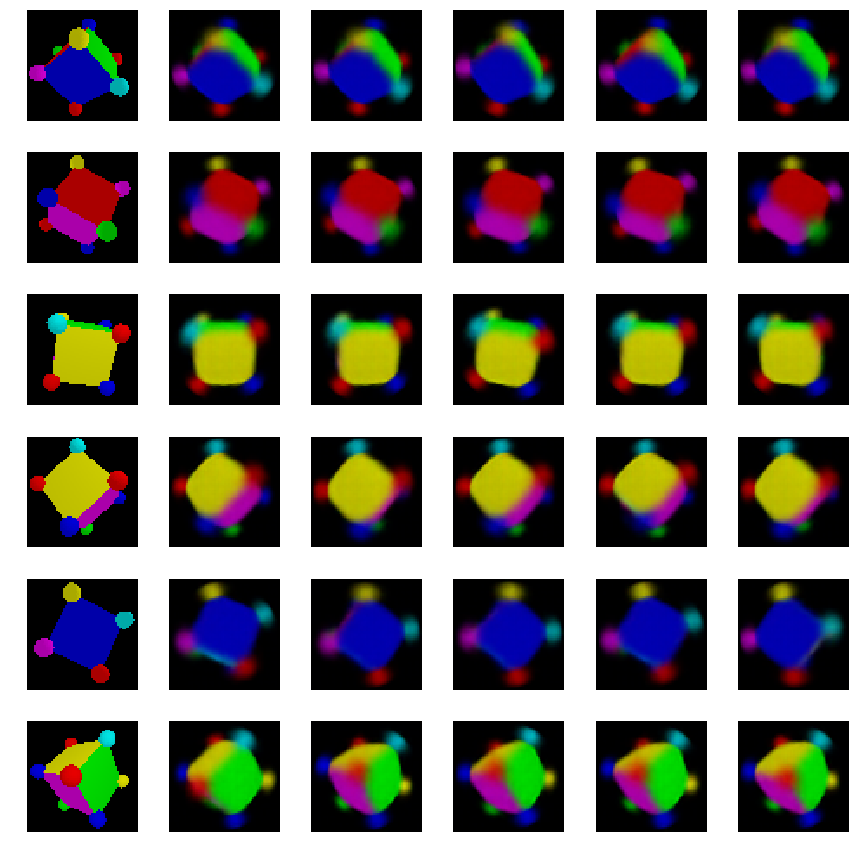

In [13]:
idxs = np.random.choice(len(spherecube_dataset), size=6, replace=False)
images = torch.stack([spherecube_dataset[i][2] for i in idxs], 0).to(device)
recon = sc_action.forward(images, n=5).transpose(0, 1).contiguous()
print(sc_action.z[0].reshape(5, 6, 9).var(dim=0).sum(-1))
noise = sc_action.rep_group.reparameterize.z
recon = torch.cat([images[:, None], recon], 1)
plot_output(recon.view(-1, 3, 64, 64), rgb=True)

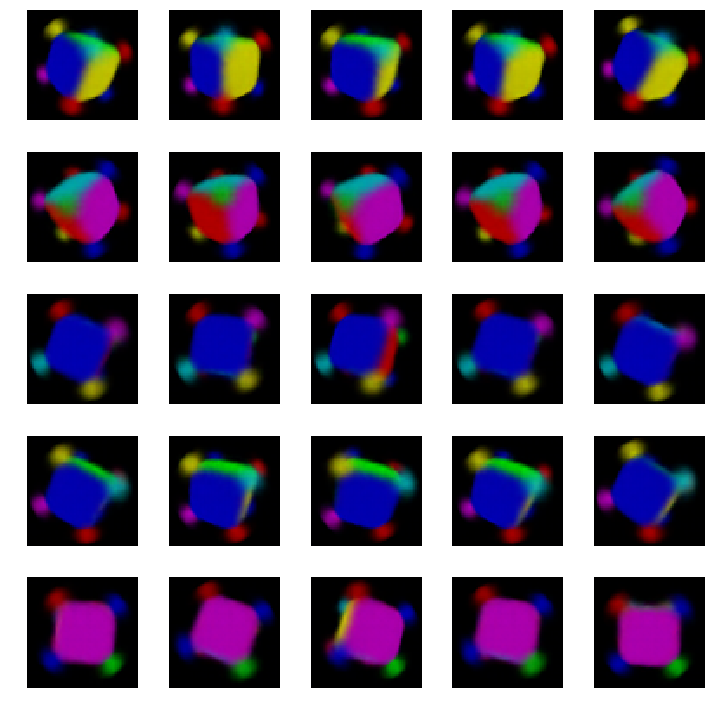

tensor(1.00000e-02 *
       [ 9.5655,  9.5655,  9.5655,  9.5655,  9.5655], device='cuda:0')


In [15]:
idxs = np.random.choice(len(spherecube_dataset), size=5, replace=False)
images = torch.stack([spherecube_dataset[i][2] for i in idxs], 0).to(device)
encodings = expand_dim(sc_action.encode(images, n=1)[0][0], 5, 1)

scale = 2 * np.pi / 60
d = expand_dim(rodrigues(scale * torch.randn(5, 3, device=device)), 5, 0)
# r = d.matmul(encodings)
r = encodings.matmul(d)


recon = sc_action.decode(r).view(25, *images[0].shape)
plot_output(recon, rgb=True)
plt.show()
print(r.reshape(5, 5, 9).var(dim=1).sum(-1))

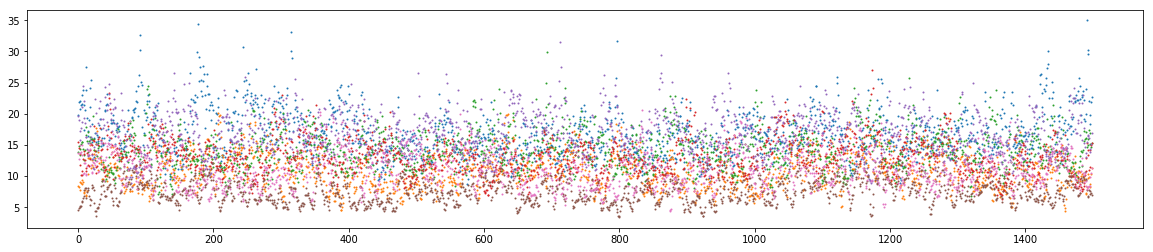

In [16]:
plt.figure(figsize=(20, 4))
for _ in range(7):
    n1 = 100
    n2 = 5
    n3 = 3
    g1 = rotation_interpolation(n1, device=device).repeat(n2*n3, 1, 1)
    g2 = rotation_interpolation(n1*n2, device=device).repeat(n3, 1, 1)
    g3 = rotation_interpolation(n1*n2*n3, device=device)
    mu = torch.tensor(random_group_matrices(1, device=device)).expand_as(g1)
    g = mu.bmm(g1).bmm(g2).bmm(g3)
    out = sc_action.decode(g[None])[0]
    n = n1*n2*n3
    d = (out[:-1] - out[1:]).pow(2).view(n-1, -1).sum(1)
    plt.scatter(np.arange(n-1), d.detach().cpu().numpy(), s=1)
plt.show()

In [9]:
scale = 2 * np.pi / 60
r = rodrigues(scale * torch.randn(100, 3))
d = r - torch.eye(3)[None]
d.pow(2).view(-1, 9).sum(-1).mean()

tensor(1.00000e-02 *
       5.9919)

In [24]:
l = torch.utils.data.DataLoader(scpairs_dataset, batch_size=32)
for batch in l:
    g = scpairs_dataset.prep_batch(batch)[1].view(-1, 2, 3, 3)
    a, b = g[1:, 0], g[:-1, 1]
    print((a-b).pow(2).view(-1, 9).mean())
    break

tensor(0.7015)


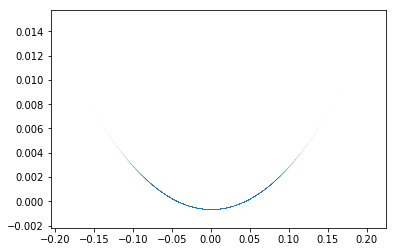

In [190]:
n = 100000
v_hat = torch.tensor([1., 0., 0])
r = torch.randn(n) * 0.03
v = r[:, None] * v_hat[None]
g = rodrigues(v)
# ax = Axes3D(plt.figure())
from sklearn.decomposition import PCA
# from mpl_toolkits.mplot3d import Axes3D
x = PCA(2).fit_transform(g.view(-1, 9))
plt.scatter(*x.T, s=.1, alpha=.01)
plt.show()

In [187]:
np.linalg.norm(x-x.mean(axis=1, keepdims=True), axis=1)

array([0.90193844, 0.94654008, 0.27487955, ..., 0.76408086, 0.80562801,
       1.39397994])

In [81]:
from collections import OrderedDict
from functools import partial
import re
def trasform_state_keys(pattern, fn, state):
    """Transformed saved state"""
    return OrderedDict(
        [(re.sub(pattern, fn, k), v) for k, v in state.items()]
    )

# For change in deconv nn.Sequential
transform_state_deconv = partial(trasform_state_keys, r'deconv\.(\d)+', lambda i: 'deconv.'+str(int(i.group(1))+1))

def load_transform_deconv(path):
    return transform_state_deconv(torch.load(path))

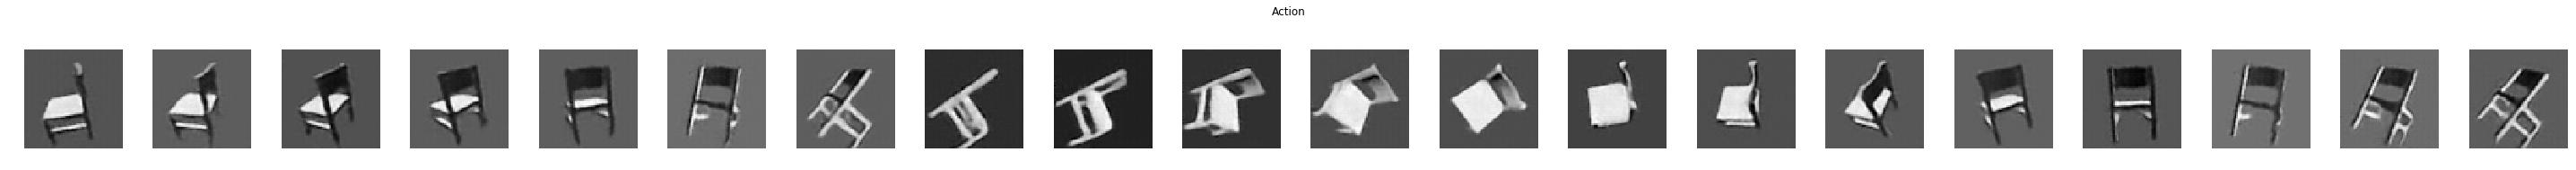

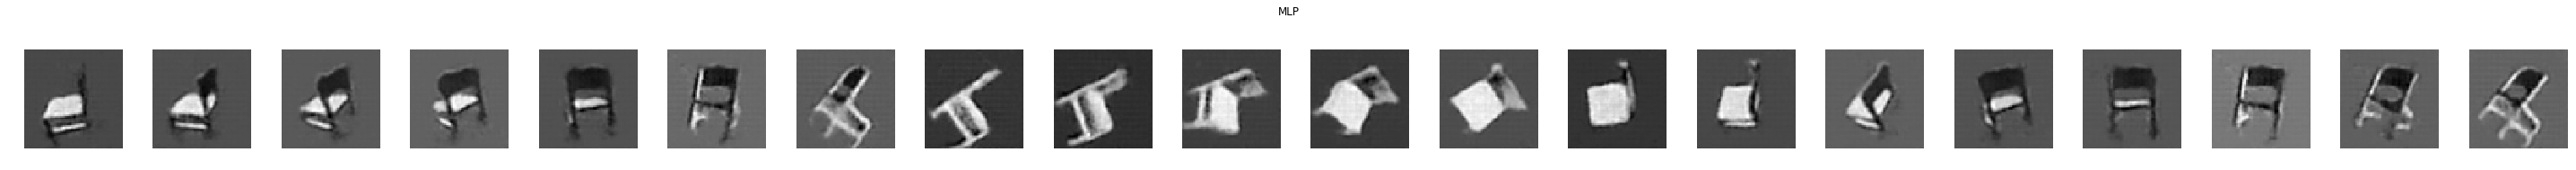

In [4]:
action_net = ActionNet(6, ChairsDeconvNet(490, 50))
action_net.load_state_dict(load_transform_deconv('outputs/supervised_outputs/action.pickle'))
mlp_net = MLPNet(6, ChairsDeconvNet(490, 50))
mlp_net.load_state_dict(load_transform_deconv('outputs/supervised_outputs/mlp.pickle'))

# rot = rotation_interpolation()
rot = rotation_random_walk()
action_outputs = action_net(rot)
mlp_outputs = mlp_net(rot)
    
plot_output(action_outputs, 'Action')
plot_output(mlp_outputs, 'MLP')

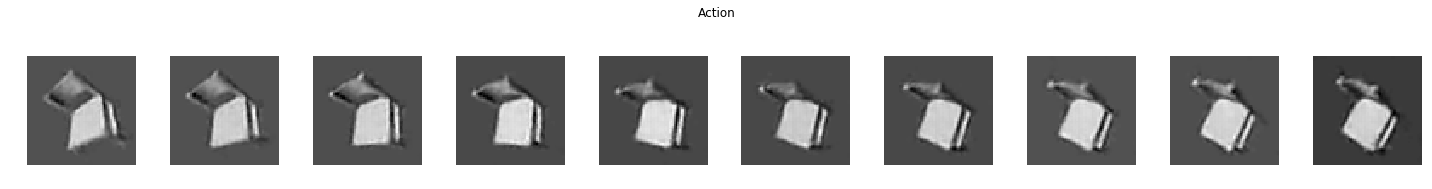

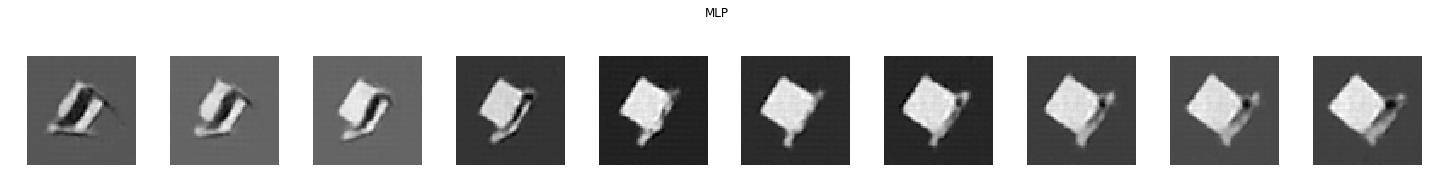

In [5]:
action_net = ActionNet(3, ChairsDeconvNet(160, 50))
action_net.load_state_dict(load_transform_deconv('outputs/ae_outputs/action_100.pickle'))
action_net_enc = ChairsEncoder()
state = torch.load('outputs/ae_outputs/action_100_enc.pickle')
for i in range(0, 10, 2):  # Trained without bias
    state['conv.%d.bias' % i] = torch.zeros(state['conv.%d.weight' % i].size(0))
action_net_enc.load_state_dict(state)

action_net_fat = ActionNet(8, ChairsDeconvNet(810, 200))
action_net_fat.load_state_dict(load_transform_deconv('outputs/ae_outputs/fat/action_100.pickle'))
action_net_enc_fat = ChairsEncoder()
state = torch.load('outputs/ae_outputs/fat/action_100_enc.pickle')
for i in range(0, 10, 2):  # Trained without bias
    state['conv.%d.bias' % i] = torch.zeros(state['conv.%d.weight' % i].size(0))
action_net_enc_fat.load_state_dict(state)

rot = rotation_interpolation()
action_outputs = action_net(rot)
action_fat_outputs = action_net_fat(rot)
mlp_outputs = mlp_net(rot)
    
# plot_output(action_outputs, 'Action')
plot_output(action_fat_outputs, 'Action')
plot_output(mlp_outputs, 'MLP')

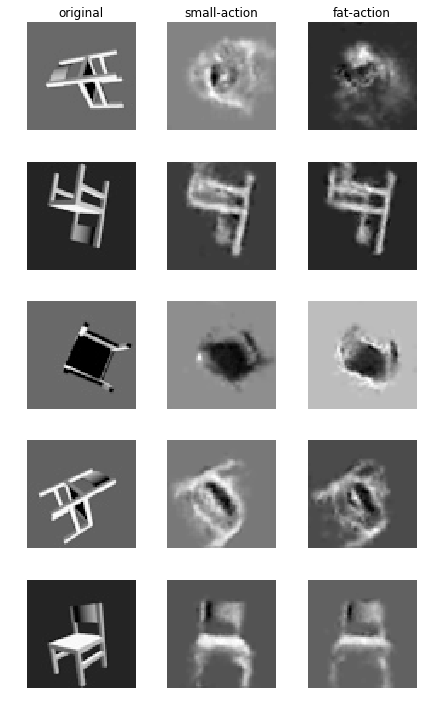

In [6]:
dataset = ShapeDataset('data/chairs/single/')
idxs = np.random.choice(len(dataset), size=5, replace=False)
images = torch.stack([dataset[i][2] for i in idxs], 0)
reconstructions = action_net(action_net_enc(images)[0])
reconstructions_fat = action_net_fat(action_net_enc_fat(images)[0])
    
plot_reconstructions([images, reconstructions, reconstructions_fat],
                     ['original', 'small-action', 'fat-action'])

In [10]:
# multi_action_dec = ActionNet(3, single_id=False)
# multi_action_dec.load_state_dict(torch.load('multi_outputs/ae-action/action_4.pickle'))
# multi_action_enc = Encoder(id_dims=10)
# multi_action_enc.load_state_dict(torch.load('multi_outputs/ae-action/action_4_enc.pickle'))

multi_action_dec_fat = ActionNet(6, ChairsDeconvNet(490, 200), single_id=False, content_dims=30)
multi_action_dec_fat.load_state_dict(load_transform_deconv('outputs/multi_outputs/ae-action-fat/action_7.pickle'))
multi_action_enc_fat = ChairsEncoder(content_dims=30)
multi_action_enc_fat.load_state_dict(torch.load('outputs/multi_outputs/ae-action-fat/action_7_enc.pickle'))


multi_mlp_dec = MLPNet(3, ChairsDeconvNet(160, 200), single_id=False, content_dims=30)
multi_mlp_dec.load_state_dict(load_transform_deconv('outputs/multi_outputs/ae-mlp/mlp_9.pickle'))
multi_mlp_enc = ChairsEncoder(content_dims=30)
multi_mlp_enc.load_state_dict(torch.load('outputs/multi_outputs/ae-mlp/mlp_9_enc.pickle'))

multi_action_dec_fat8 = ActionNet(6, ChairsDeconvNet(490, 200), single_id=False, content_dims=8)
multi_action_dec_fat8.load_state_dict(load_transform_deconv('outputs/multi_outputs/ae-action-fat-cv8/dec.pickle'))
multi_action_enc_fat8 = ChairsEncoder(content_dims=8)
multi_action_enc_fat8.load_state_dict(torch.load('outputs/multi_outputs/ae-action-fat-cv8/enc.pickle'))


multi_mlp_dec8 = MLPNet(3, ChairsDeconvNet(160, 200), single_id=False, content_dims=8)
multi_mlp_dec8.load_state_dict(load_transform_deconv('outputs/multi_outputs/ae-mlp-cv8/dec.pickle'))
multi_mlp_enc8 = ChairsEncoder(content_dims=8)
multi_mlp_enc8.load_state_dict(torch.load('outputs/multi_outputs/ae-mlp-cv8/enc.pickle'))

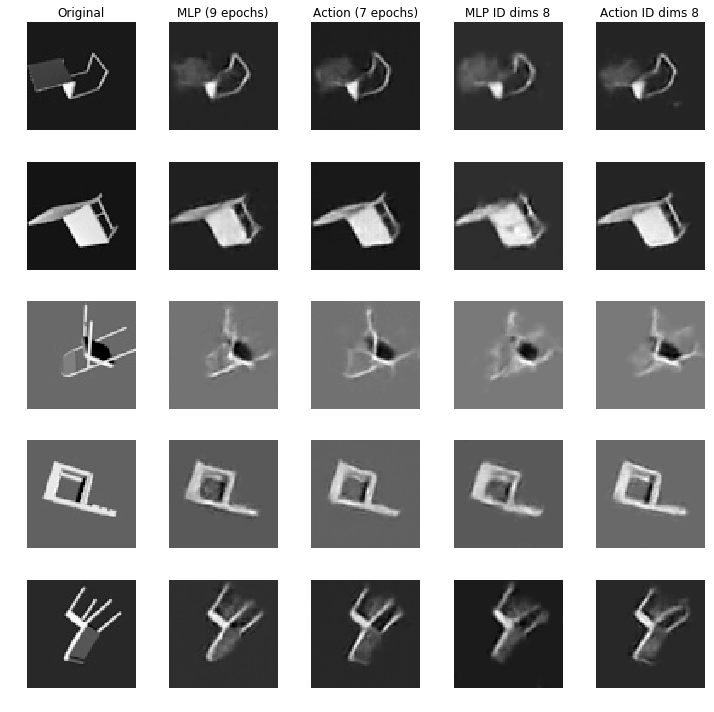

In [11]:
idxs = np.random.choice(len(multi_dataset), size=5, replace=False)
id_label, rot_label, img_label = zip(*[multi_dataset[i] for i in idxs])
id_label = torch.tensor(id_label, dtype=torch.long)
rot_label = torch.stack(rot_label, 0)
img_label = torch.stack(img_label, 0)

action_rec = multi_action_dec_fat(*multi_action_enc_fat(img_label))
mlp_rec = multi_mlp_dec(*multi_mlp_enc(img_label))
action_rec8 = multi_action_dec_fat8(*multi_action_enc_fat8(img_label))
mlp_rec8 = multi_mlp_dec8(*multi_mlp_enc8(img_label))
    
plot_reconstructions([img_label, mlp_rec, action_rec, mlp_rec8, action_rec8],
                     ['Original', 'MLP (9 epochs)', 'Action (7 epochs)', 'MLP ID dims 8', 'Action ID dims 8'])

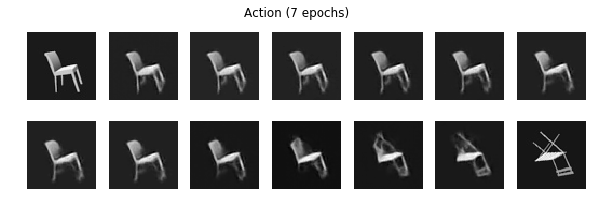

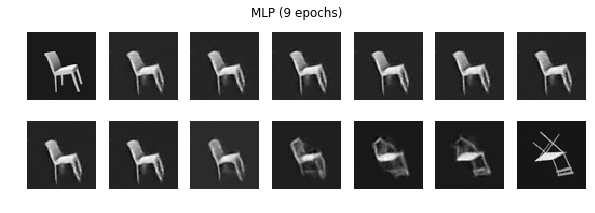

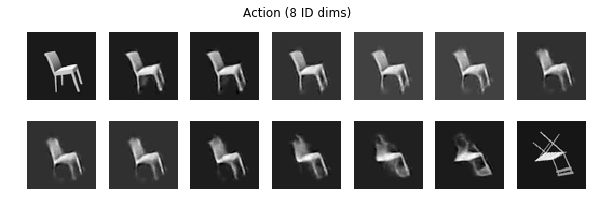

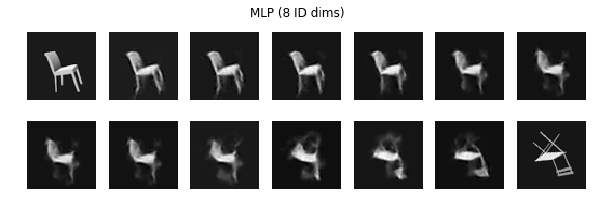

In [12]:
idxs = np.random.choice(len(multi_dataset), size=2, replace=False)
img = torch.stack([multi_dataset[i][2] for i in idxs])


    
disentangle(multi_action_enc_fat, multi_action_dec_fat, img[0], img[1], 'Action (7 epochs)')
disentangle(multi_mlp_enc, multi_mlp_dec, img[0], img[1], 'MLP (9 epochs)')
disentangle(multi_action_enc_fat8, multi_action_dec_fat8, img[0], img[1], 'Action (8 ID dims)')
disentangle(multi_mlp_enc8, multi_mlp_dec8, img[0], img[1], 'MLP (8 ID dims)')

In [13]:
def mean_module_rewrite(params):
    for a, b in zip(["rep_group.mean_module.map.weight", "rep_group.mean_module.map.bias", "reparameterize.0.mean_module.map.weight", "reparameterize.0.mean_module.map.bias"], ["rep_group.mu_linear.weight", "rep_group.mu_linear.bias", "reparameterize.0.mu_linear.weight", "reparameterize.0.mu_linear.bias"]):
        params[a] = params[b]
        del params[b]
    return params

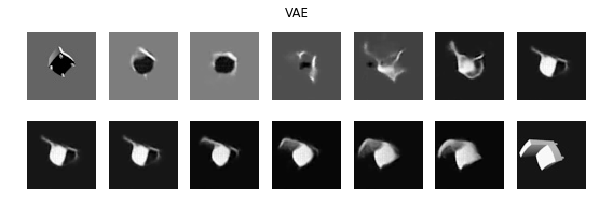

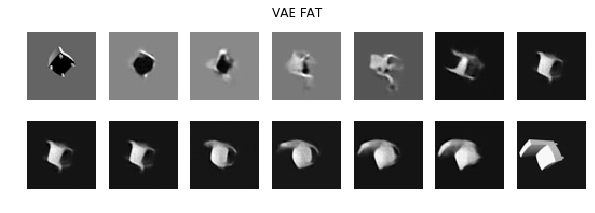

In [14]:
idxs = np.random.choice(len(multi_dataset), size=2, replace=False)
img = torch.stack([multi_dataset[i][2] for i in idxs])

vae = ChairsVAE(
    content_dims=10,
    latent_mode='so3',
    decoder_mode='action',
    deconv_hidden=50)
vae.load_state_dict(mean_module_rewrite(torch.load('outputs/vae-action-so3-betae-3/model.pickle')))
vae_fat = ChairsVAE(
    content_dims=10,
    latent_mode='so3',
    decoder_mode='action',
    deconv_hidden=200)
vae_fat.load_state_dict(mean_module_rewrite(torch.load('outputs/vae-action-so3-fat-betasa/model.pickle')))



disentangle(partial(encode_vae, vae), partial(decode_vae, vae), img[0], img[1], 'VAE')
disentangle(partial(encode_vae, vae_fat), partial(decode_vae, vae_fat), img[0], img[1], 'VAE FAT')

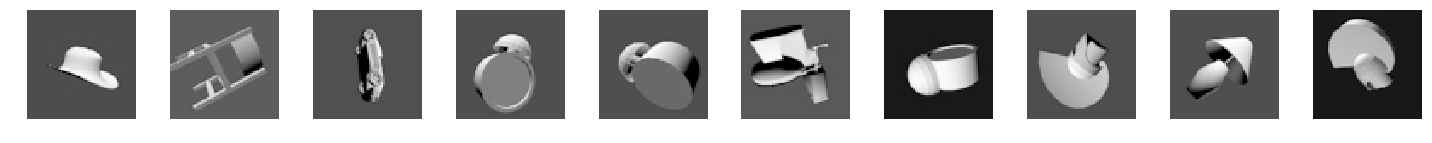

In [15]:
idxs = np.random.choice(len(obj_dataset), size=10, replace=False)
imgs = torch.stack([obj_dataset[i][2] for i in idxs])
plot_output(imgs)

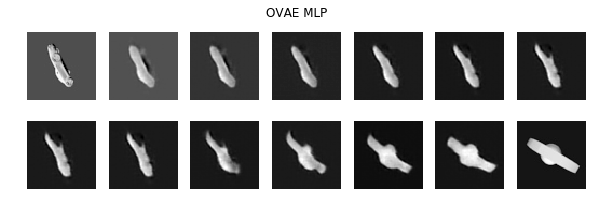

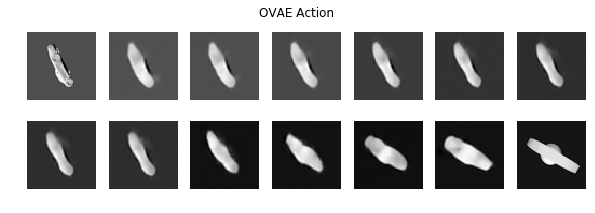

In [16]:
ovae_mlp = ChairsVAE(
    latent_mode='so3',
    decoder_mode='mlp',
    deconv_hidden=200)
ovae_mlp.load_state_dict(mean_module_rewrite(torch.load('outputs/ovae-mlp-so3-fat-betasc/model.pickle')))

ovae_action = ChairsVAE(
    latent_mode='so3',
    decoder_mode='action',
    deconv_hidden=200)
ovae_action.load_state_dict(mean_module_rewrite(torch.load('outputs/ovae-action-so3-fat-betasc/model.pickle')))

idxs = np.random.choice(len(obj_dataset), size=2, replace=False)
img = torch.stack([obj_dataset[i][2] for i in idxs])
disentangle(partial(encode_vae, ovae_mlp), partial(decode_vae, ovae_mlp), img[0], img[1], 'OVAE MLP')
disentangle(partial(encode_vae, ovae_action), partial(decode_vae, ovae_action), img[0], img[1], 'OVAE Action')

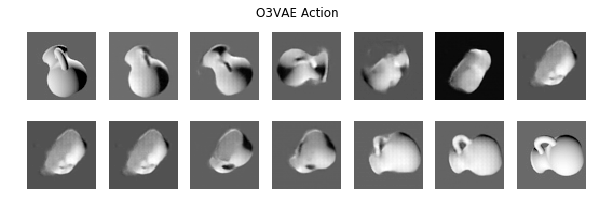

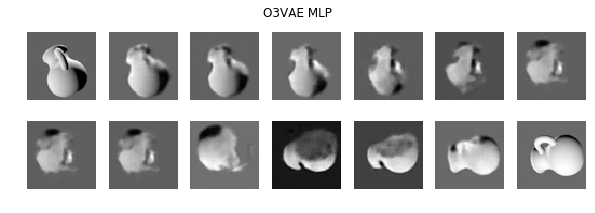

In [17]:
o3vae_action = ChairsVAE(
    latent_mode='so3',
    decoder_mode='action',
    deconv_hidden=200,
    content_dims=3)
o3vae_action.load_state_dict(mean_module_rewrite(torch.load('outputs/o3vae-action-so3-fat-betase/model.pickle')))

o3vae_mlp = ChairsVAE(
    latent_mode='so3',
    decoder_mode='mlp',
    deconv_hidden=200,
    content_dims=3)
o3vae_mlp.load_state_dict(mean_module_rewrite(torch.load('outputs/o3vae-mlp-so3-fat-betasc/model.pickle')))

idxs = np.random.choice(len(obj3_dataset), size=2, replace=False)
img = torch.stack([obj3_dataset[i][2] for i in idxs])
disentangle(partial(encode_vae, o3vae_action), partial(decode_vae, o3vae_action), img[0], img[1], 'O3VAE Action')
disentangle(partial(encode_vae, o3vae_mlp), partial(decode_vae, o3vae_mlp), img[0], img[1], 'O3VAE MLP')

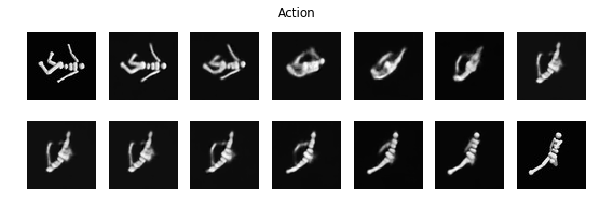

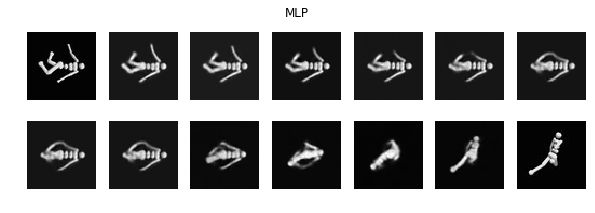

In [18]:
hvae_action = ChairsVAE(
    latent_mode='so3',
    decoder_mode='action',
    deconv_hidden=200)
hvae_action.load_state_dict(mean_module_rewrite(torch.load('outputs/hvae-action-so3-fat-betase/model.pickle')))

hvae_mlp = ChairsVAE(
    latent_mode='so3',
    decoder_mode='mlp',
    deconv_hidden=200)
hvae_mlp.load_state_dict(mean_module_rewrite(torch.load('outputs/hvae-mlp-so3-fat-betase/model.pickle')))

idxs = np.random.choice(len(humanoid_dataset), size=2, replace=False)
img = torch.stack([humanoid_dataset[i][2] for i in idxs])
disentangle(partial(encode_vae, hvae_action), partial(decode_vae, hvae_action), img[0], img[1], 'Action')
disentangle(partial(encode_vae, hvae_mlp), partial(decode_vae, hvae_mlp), img[0], img[1], 'MLP')

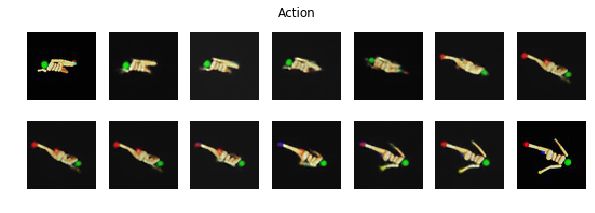

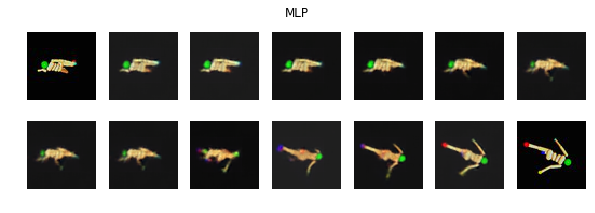

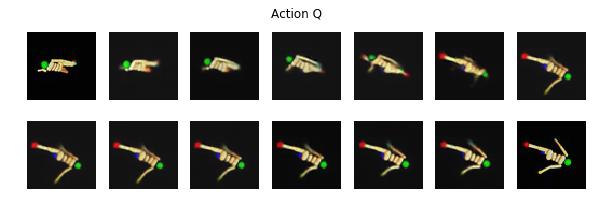

In [19]:
chvae_action = ChairsVAE(
    latent_mode='so3',
    decoder_mode='action',
    deconv_hidden=200,
    rgb=True)
chvae_action.load_state_dict(mean_module_rewrite(torch.load('outputs/chvae-action-so3-fat-betasg/model.pickle')))

chvae_mlp = ChairsVAE(
    latent_mode='so3',
    decoder_mode='mlp',
    deconv_hidden=200,
    rgb=True)
chvae_mlp.load_state_dict(mean_module_rewrite(torch.load('outputs/chvae-mlp-so3-fat-betase/model.pickle')))

chvae_q = ChairsVAE(
    latent_mode='so3',
    decoder_mode='action',
    mean_mode='q',
    deconv_hidden=200,
    rgb=True)
chvae_q.load_state_dict(mean_module_rewrite(torch.load('outputs/cshvae-action-so3-fat-q-beta0.3/model.pickle')))

idxs = np.random.choice(len(chumanoid_dataset), size=2, replace=False)
img = torch.stack([chumanoid_dataset[i][2] for i in idxs])
disentangle(partial(encode_vae, chvae_action), partial(decode_vae, chvae_action), img[0], img[1], 'Action', rgb=True)
disentangle(partial(encode_vae, chvae_mlp), partial(decode_vae, chvae_mlp), img[0], img[1], 'MLP', rgb=True)
disentangle(partial(encode_vae, chvae_q), partial(decode_vae, chvae_q), img[0], img[1], 'Action Q', rgb=True)

In [20]:
chair_action_local = ChairsVAE(
    latent_mode='so3',
    decoder_mode='action',
    deconv_hidden=200,
    single_id=True)
chair_action_local.load_state_dict(mean_module_rewrite(torch.load('outputs/chair-action-so3-fat-betash_local/model.pickle')))

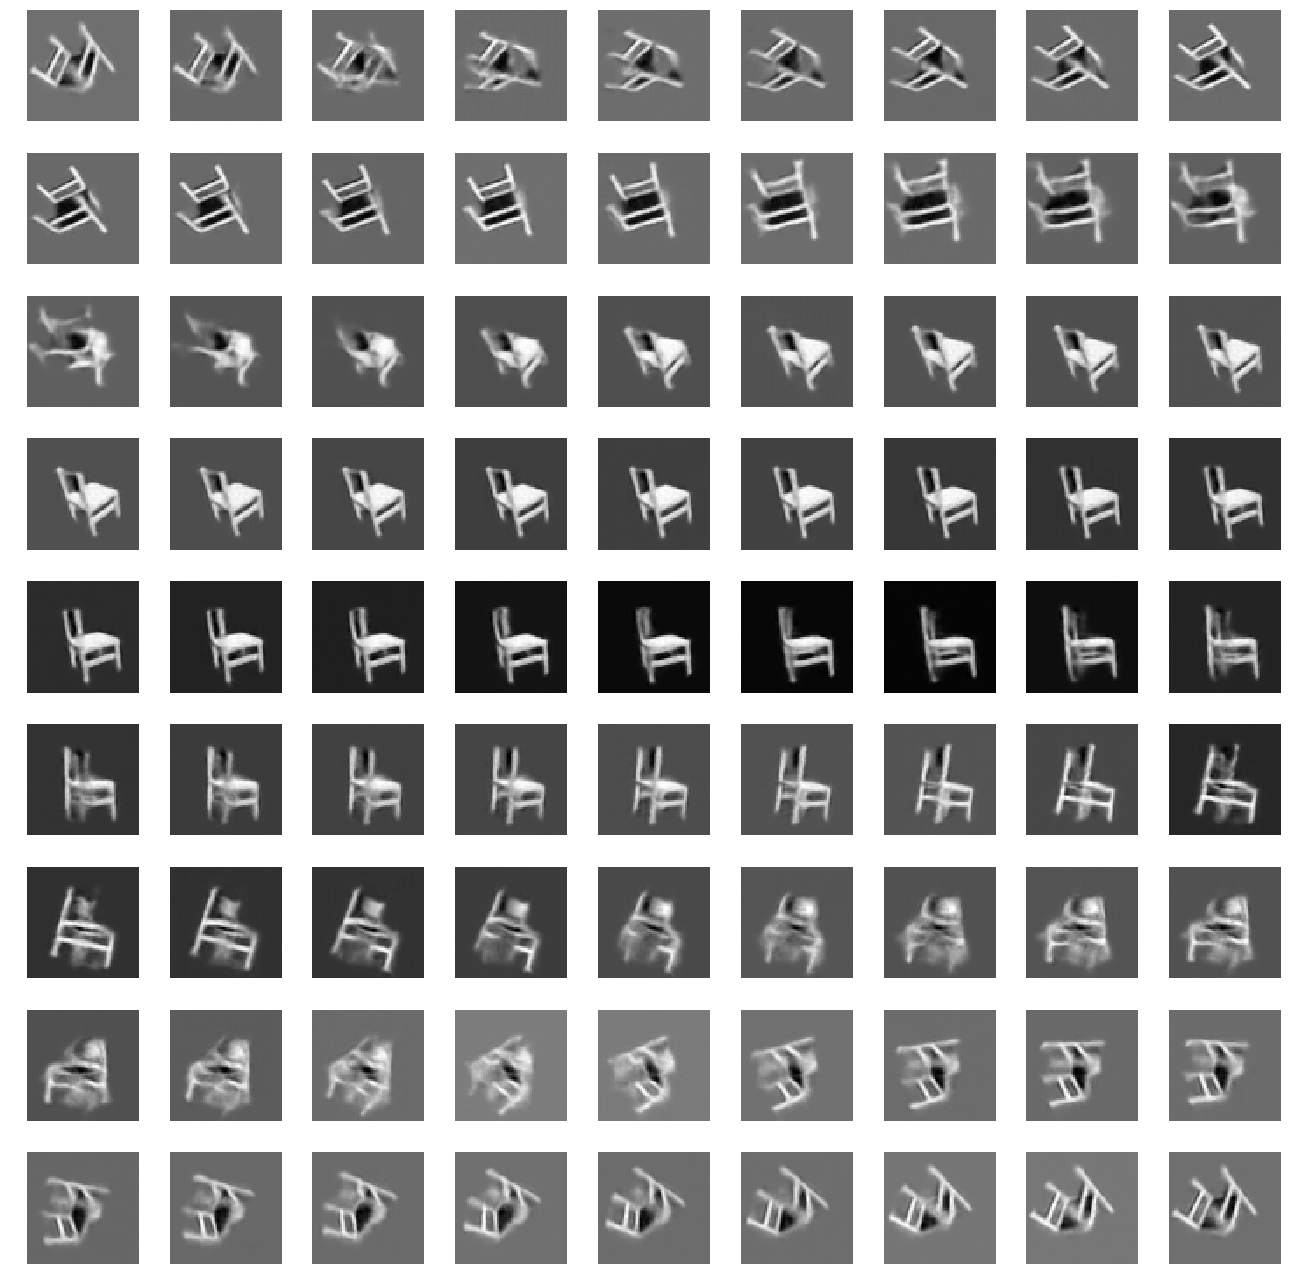

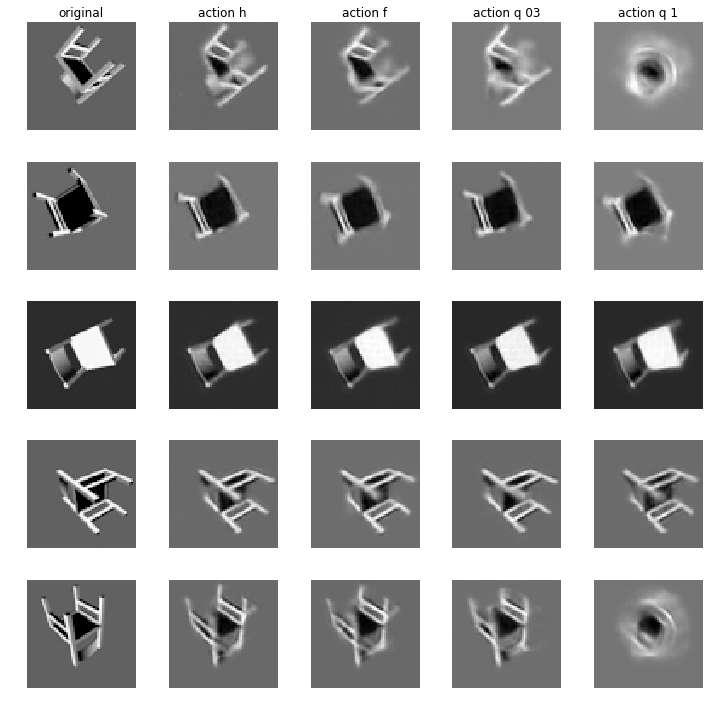

In [21]:


chair_action = ChairsVAE(
    latent_mode='so3',
    decoder_mode='action',
    deconv_hidden=200,
    single_id=True)
chair_action.load_state_dict(mean_module_rewrite(torch.load('outputs/chair-action-so3-fat-betash/model.pickle')))
chair_actionf = ChairsVAE(
    latent_mode='so3',
    decoder_mode='action',
    deconv_hidden=200,
    single_id=True)
chair_actionf.load_state_dict(mean_module_rewrite(torch.load('outputs/chair-action-so3-fat-betasf/model.pickle')))
chair_action_q_03 = ChairsVAE(
    latent_mode='so3',
    decoder_mode='action',
    deconv_hidden=200,
    single_id=True,
    mean_mode='q')
chair_action_q_03.load_state_dict(mean_module_rewrite(torch.load('outputs/chair-action-so3-fat-q-beta0.3/model.pickle')))
chair_action_q_1 = ChairsVAE(
    latent_mode='so3',
    decoder_mode='action',
    mean_mode='q',
    deconv_hidden=200,
    single_id=True)
chair_action_q_1.load_state_dict(mean_module_rewrite(torch.load('outputs/chair-action-so3-fat-q-beta1/model.pickle')))

g = rotation_interpolation(81)
g[0] = torch.eye(3)

mu = torch.tensor(randomR()).float()[None].expand_as(g)
g = mu.bmm(g)
# print('Action, schedule H')
# out_action = chair_action.decode(g[None])[0]
# plot_output(out_action, 'Action H')
# plt.show()

out_action = chair_action_q_03.decode(g[None])[0]
plot_output(out_action)
plt.show()

idxs = np.random.choice(len(single_dataset), size=5, replace=False)
# print(idxs)
images = torch.stack([single_dataset[i][2] for i in idxs], 0)
reconstructions = chair_action(images)[0]
reconstructionsf = chair_actionf(images)[0]
reconstructions_q_03 = chair_action_q_03(images)[0]
reconstructions_q_1 = chair_action_q_1(images)[0]
# reconstructions_q_03 = chair_action_q_03(images)[0]

# code = chair_action.encode(images)[0][0]
# convcode = chair_action.encoder(images)
# print(group_matrix_to_eazyz(code))
    
plot_reconstructions([images, reconstructions, reconstructionsf, reconstructions_q_03, reconstructions_q_1],
                     ['original', 'action h', 'action f', 'action q 03', 'action q 1'])

In [ ]:
plt.figure(figsize=(20, 5))
for _ in range(10):
    g = rotation_interpolation(200)
    g[0] = torch.eye(3)
    mu = torch.tensor(randomR()).float()[None].expand_as(g)
    g = mu.bmm(g)
    out = sc_action.decode(g[None])[0]
    diff = (out[:-1] - out[1:]).pow(2).sum(-1).sum(-1).sum(-1)
    plt.plot(diff.detach().numpy())
plt.show()

In [9]:
from torch.utils.data import DataLoader

def dataset_mse(dataset, ref, frobenious=False):
    distances = torch.zeros(len(dataset))
    batch_size = 64*20
    loader = DataLoader(
        dataset, shuffle=False, batch_size=batch_size,
        drop_last=False, num_workers=20)
    from tqdm import tqdm
    for i, batch in enumerate(tqdm(loader)):
        x = batch[0] if frobenius else batch[2]
        d = (ref[None]-x).pow(2).view(len(x), -1).sum(1)
        distances[i * batch_size : (i+1) * batch_size] = d
    return distances

In [ ]:
ref_i = np.random.randint(len(spherecube_dataset))
ref_img = spherecube_dataset[ref_i][2]
distances = dataset_mse(spherecube_dataset, ref_img)

idxs = distances.sort()[1][:25]
imgs = [spherecube_dataset[i][2] for i in idxs]
plot_output(imgs, rgb=True)

In [ ]:
ref_i = np.random.randint(len(single_dataset))
ref_img = spherecube_dataset[ref_i][2]
distances = dataset_mse(single_dataset, ref_img)

idxs = distances.sort()[1][:25]
imgs = [single_dataset[i][2] for i in idxs]
plot_output(imgs, rgb=False)

## Dataset NN

In [10]:
spherecube_dataset_subsample = SphereCubeDataset(0.06)
len(spherecube_dataset), len(spherecube_dataset_subsample)
ref = spherecube_dataset[0][2]
mse = dataset_mse(spherecube_dataset, ref)
mse_subsample = dataset_mse(spherecube_dataset_subsample, ref)

100%|██████████| 47/47 [00:07<00:00,  6.43it/s]


In [12]:
mse.sort()[0], mse_subsample.sort()

(tensor([    0.0000,    43.8564,    49.5208,  ...,  1941.8616,
          1942.4225,  1946.6458]),
 (tensor([   98.4876,   151.0171,   174.4881,  ...,  1932.7693,
           1933.9365,  1936.5264]),
  tensor([ 48560,  54708,  25927,  ...,  35679,  44750,   5229])))

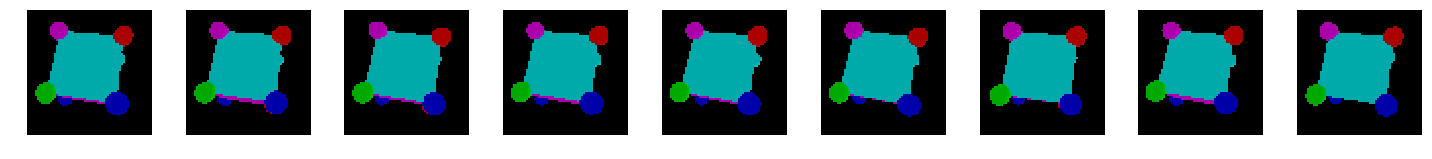

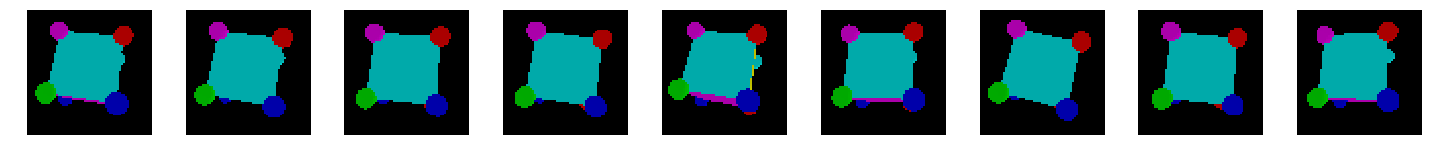

In [43]:
imgs = [spherecube_dataset[i][2] for i in mse.sort()[1][:9]]
plot_output(imgs, rgb=True, shape=(1, 9), size=(20, 5))
imgs = [ref]+[spherecube_dataset_subsample[i][2] for i in mse_subsample.sort()[1][:8]]
plot_output(imgs, rgb=True, shape=(1, 9), size=(20, 5))